In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df_sample = pd.read_csv("data/sample_submission.csv")
df_train  = pd.read_csv("data/train.csv")
df_test   = pd.read_csv("data/train.csv")

# drop id (not useful)
df_train.drop('id',axis=1,inplace=True)
df_test.drop('id',axis=1,inplace=True)

In [4]:
print(df_train.shape)

(20758, 17)


In [5]:
# number of na
mv = df_train.isna().sum().sum()

# number of duplicates
dv = df_train.duplicated().sum()

# there are no NAs or Duplicates in the test dataset
print(mv)
print(dv)

0
0


In [6]:
display(df_train.describe(include=[np.number]).T, df_train.describe(include=[object]).T)

,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000


,count,unique,top,freq
Gender,20758,2,Female,10422
family_history_with_overweight,20758,2,yes,17014
FAVC,20758,2,yes,18982
CAEC,20758,4,Sometimes,17529
SMOKE,20758,2,no,20513
SCC,20758,2,no,20071
CALC,20758,3,Sometimes,15066
MTRANS,20758,5,Public_Transportation,16687
NObeyesdad,20758,7,Obesity_Type_III,4046


In [7]:
numerical_cols   = df_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df_train.select_dtypes(include=[object]).columns.tolist()

num_numerical_cols = len(numerical_cols)
num_numerical_rows = num_numerical_cols // 4

num_categorical_cols = len(categorical_cols)
num_categorical_rows = num_categorical_cols // 4

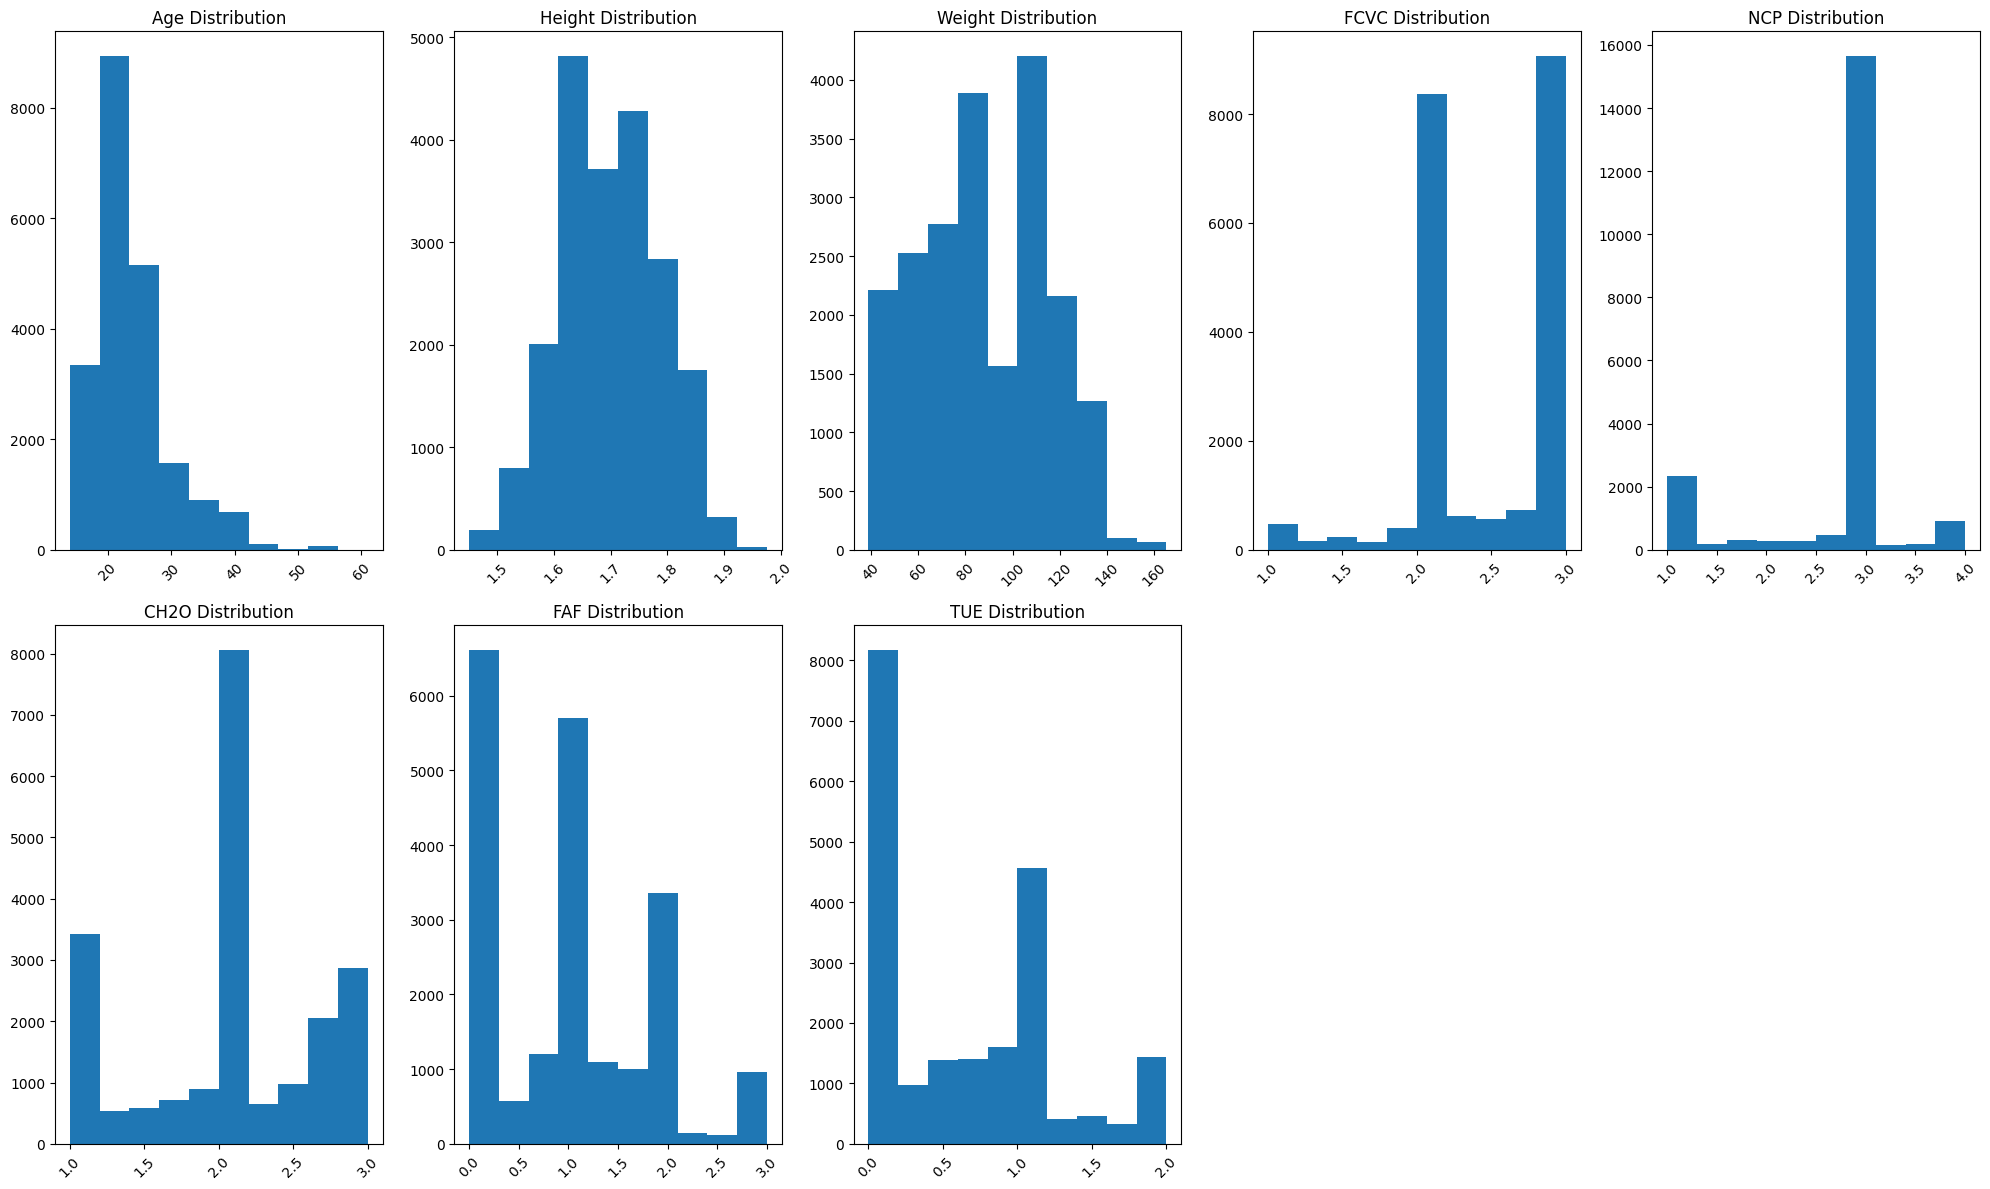

In [8]:
# numerical cols histogram
plt.figure(figsize=(20,6 * num_numerical_rows))
for i ,col in enumerate(numerical_cols,1):
    plt.subplot(num_numerical_rows, 5, i)
    plt.hist(df_train[col])
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 


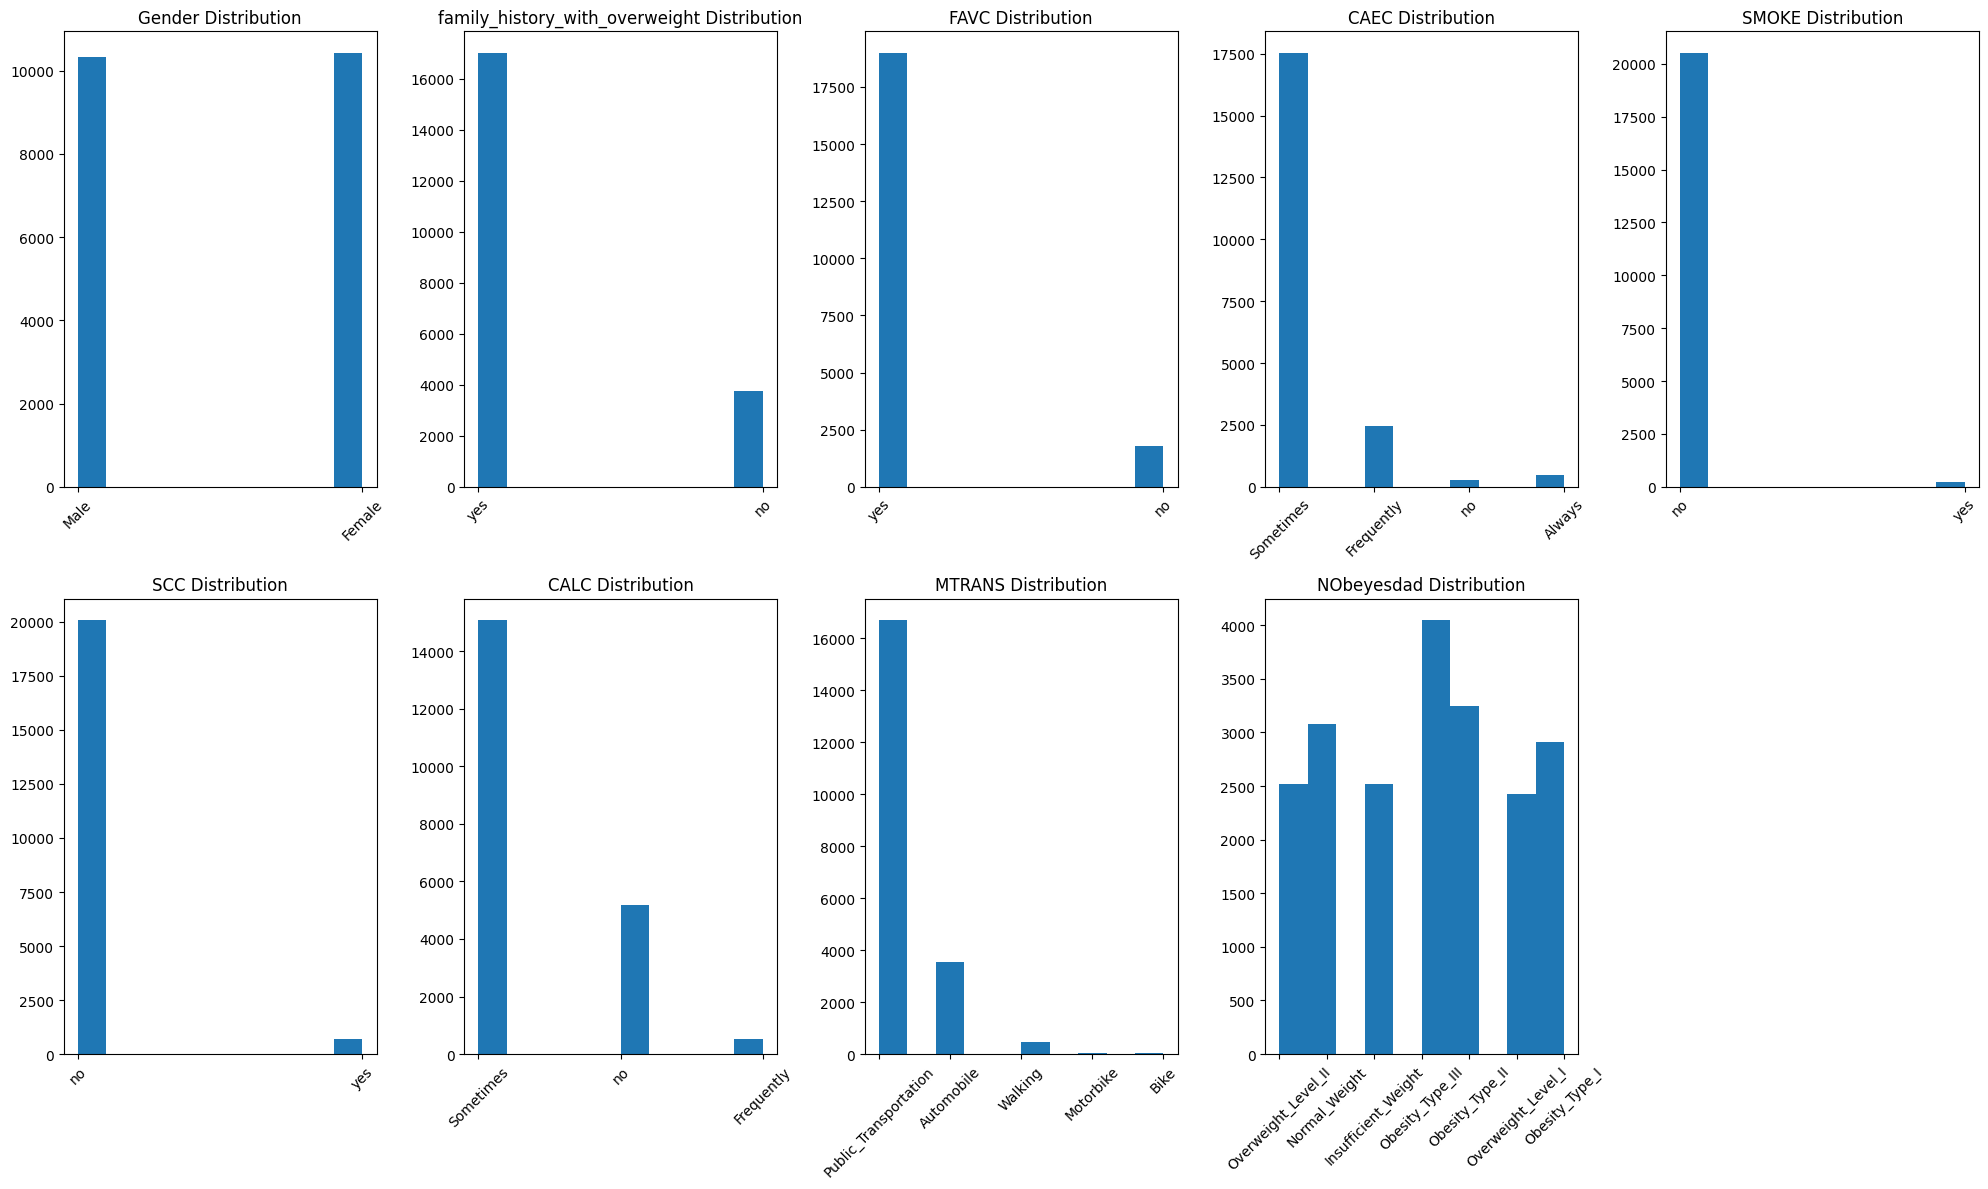

In [9]:
# categorical cols histogram
plt.figure(figsize=(20,6 * num_categorical_rows))
for i ,col in enumerate(categorical_cols,1):
    plt.subplot(num_categorical_rows, 5, i)
    plt.hist(df_train[col])
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 


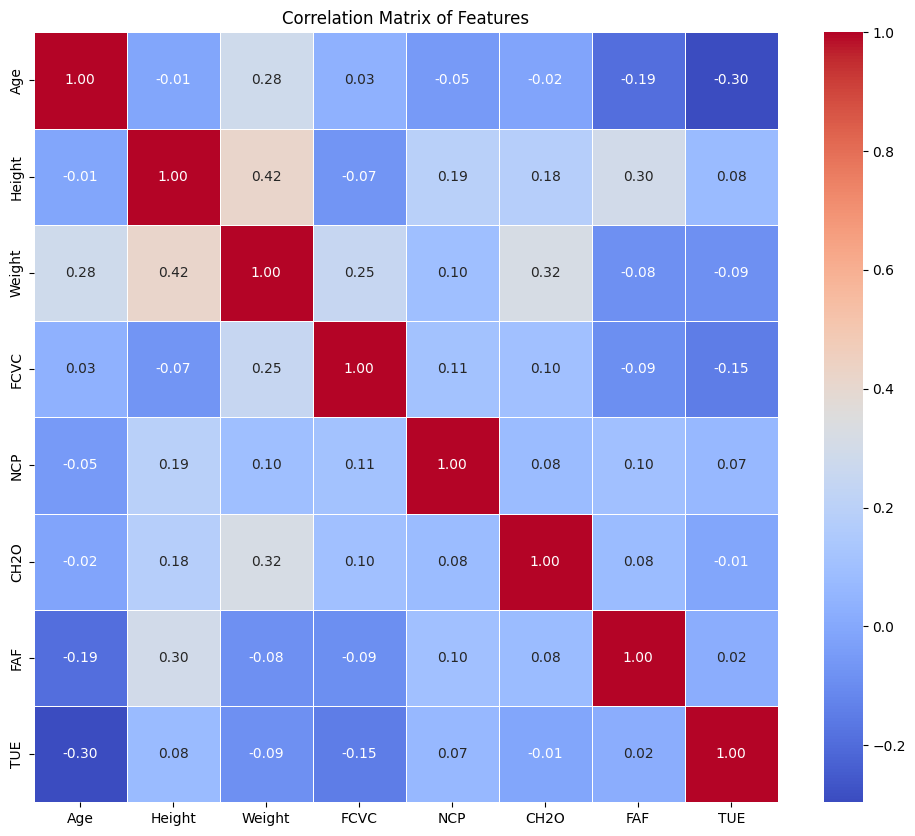

In [10]:
def corr(data):
    plt.figure(figsize=(12,10))
    sns.heatmap(data, annot=True, cmap='coolwarm', fmt='.2f', linewidths= 0.5)
    plt.title('Correlation Matrix of Features')
corr(df_train[numerical_cols].corr())